In [1]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict, Optional
from operator import itemgetter
import re
import os

In [2]:
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [3]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

def search_yt(query, max_results=3):
    try:
        # Truncate and clean query
        clean_query = re.sub(r'[^\w\s-]', '', query)[:500]
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=clean_query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [6]:
class State(TypedDict, total=False):
    topic: str
    author: str
    question: str
    objective_check: Optional[bool]
    youtube_summary: str
    recent_fact_checks: str
    validate_yt_summary: str
    validate_fact_checks: Optional[bool]
    generate_summary: str

In [5]:
def get_user_input() -> State:
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "current economic condition what is the best investment?",
        "objective_check": None,
        "youtube_summary": "",
        "recent_fact_checks": "",
        "validate_yt_summary": "",
        "validate_fact_checks": None,
        "generate_summary": ""
    }

In [7]:
def YouTube_search(state: State) -> State:
    try:
        print("\n=== Starting YouTube Search ===")
        
        items = search_yt(f"{state['topic']} {state['author']}")
        if not items:
            print("❌ No search results found")
            return state
        
        faiss_index = create_faiss_index(items)
        if not faiss_index:
            print("❌ FAISS index creation failed")
            return state

        template = """
        Analyze and respond as {author} would. Rules:
        1. Use ONLY provided context
        2. Maintain {author}'s philosophical/historical style
        3. If context is insufficient, state "I need more information"
        
        Context: {context}
        
        Question: {question}
        
        {author}'s analysis:"""
        
        
        prompt = ChatPromptTemplate.from_template(template)
        
        # Create RAG chain
        rag_chain = (
            {"context": faiss_index.as_retriever(), 
                "question": RunnablePassthrough(),
                "author": lambda _: state["author"]}
            | prompt 
            | llm
            | StrOutputParser()
        )
        question = state["question"]
        state["youtube_summary"] = rag_chain.invoke(question)
        print(state["youtube_summary"])
        return state
        
    except Exception as e:
        print(f"\n❌ Search error: {str(e)}")
        return state

In [8]:
def validate_user_input(state: State) -> State:
    try:
        prompt = f"""Is this question relevant to {state['topic']}?
        Question: {state['question']}
        Respond ONLY 'True' or 'False'"""
        
        response = llm.invoke(prompt).content.strip().lower()
        state["objective_check"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["objective_check"] = False
        return state

In [9]:
def validate_ytsummary(state: State) -> State:
    try:
        prompt = f"""Verify if this summary answers {state['question']} properly:
        Summary: {state['youtube_summary']}
        Respond 'VALID' or 'SEARCH: [keywords]'"""
        
        response = llm.invoke(prompt).content.strip()
        
        if "SEARCH:" in response:
            search_terms = re.sub(r'[^a-zA-Z0-9\s-]', '', response.split("SEARCH:")[-1])
            state["validate_yt_summary"] = f"SEARCH: {search_terms}"
        else:
            state["validate_yt_summary"] = "VALID"
            
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["validate_yt_summary"] = "SEARCH: general information"
        return state

In [10]:
def fact_checks(state: State) -> State:
    try:
        if "SEARCH:" not in state["validate_yt_summary"]:
            return state

        search_terms = state["validate_yt_summary"].split("SEARCH:")[-1]
        search = DuckDuckGoSearchRun()
        results = search.invoke(f"{state['author']} {search_terms}")
        
        state["recent_fact_checks"] = results[:1000] if results else "No additional info found"
        return state
    except Exception as e:
        print(f"Fact check error: {str(e)}")
        state["recent_fact_checks"] = "Error in fact checking"
        return state


In [11]:
def validate_facts(state: State) -> State:
    try:
        prompt = f"""Does this contain valid information?
        {state['recent_fact_checks']}
        Respond 'True' or 'False'"""
        
        response = llm.invoke(prompt).content.strip().lower()
        state["validate_fact_checks"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["validate_fact_checks"] = False
        return state

In [12]:
def consolidate_summary(state: State) -> State:
    try:
        if not state["objective_check"]:
            state["generate_summary"] = "Question not relevant to the topic"
            return state
            
        if not state["validate_fact_checks"]:
            state["generate_summary"] = "Unable to verify information"
            return state

        prompt = f"""Combine these sources in {state['author']}'s style:
        YouTube: {state['youtube_summary']}
        Fact Checks: {state['recent_fact_checks']}
        
        Answer: {state['question']}"""
        
        state["generate_summary"] = llm.invoke(prompt).content
        return state
    except Exception as e:
        print(f"Summary error: {str(e)}")
        state["generate_summary"] = "Error generating summary"
        return state

In [13]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["objective_check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected")
        return "Rejected"

In [14]:
def route_basedon_Summary(state: dict):
    """
    Route the input to the appropriate tool based on the input status
    """
    validate_yt_summary = state.get("validate_yt_summary", "")

    if validate_yt_summary == "Valid":
        print("Accepted")
        return "Accepted"
    else: "SEARCH" in validate_yt_summary
    print("need more info")
    return "need more info"
    # else:
    #     print("Error/Not relevent/Unknown Status")
    #     return "Rejected"


In [ ]:
# def route_facts(state: State):
#     """
#     Route the input to the appropriate tool based on the input status"""

#     if state["validate_fact_checks"] == True:
#         print("Accepted")
#         return "Accepted"
#     elif state["validate_fact_checks"] == False:
#         print("Rejected")
#         return "Rejected"

In [16]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [23]:
# Graph
Graphbuilder = StateGraph(State)
Graphbuilder.add_node("get_user_input", get_user_input)
Graphbuilder.add_node("YouTube_search",YouTube_search)
Graphbuilder.add_node("validate_user_input", validate_user_input)
Graphbuilder.add_node("validate_ytsummary", validate_ytsummary)
Graphbuilder.add_node("fact_checks", fact_checks)
Graphbuilder.add_node("consolidate_summary", consolidate_summary)
Graphbuilder.add_node("validate_facts", validate_facts)


Graphbuilder.add_edge(START, "get_user_input")
Graphbuilder.add_edge("get_user_input", "YouTube_search")
Graphbuilder.add_edge("YouTube_search", "validate_user_input")
Graphbuilder.add_edge("YouTube_search", "validate_ytsummary")
Graphbuilder.add_edge("fact_checks", "validate_facts")
Graphbuilder.add_edge("validate_facts", "consolidate_summary")
Graphbuilder.add_edge("consolidate_summary", END)


Graphbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "fact_checks",
        "Rejected": "consolidate_summary"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_ytsummary",
    route_basedon_Summary,
    {
        "Accepted": "consolidate_summary",
        "need more info": "fact_checks"
    }
)


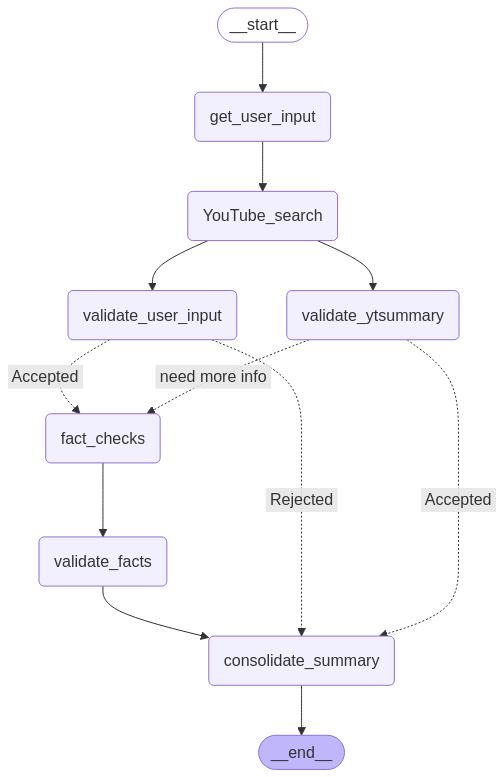

In [24]:
workflow = Graphbuilder.compile()
from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [28]:
from typing import TypedDict, Optional

class State(TypedDict, total=False):
    topic: str
    author: str
    question: str
    objective_check: Optional[bool]
    youtube_summary: str
    recent_fact_checks: str
    validate_yt_summary: str
    validate_fact_checks: Optional[bool]
    generate_summary: str

In [32]:
get_user_input(State)

Country/Area:  Rich data
News Column:  kamal
Question:  what you want


{'topic': 'Rich data', 'author': 'kamal', 'question': 'what you want'}

In [38]:
state = workflow.invoke(get_user_input())
print("Final State: ", state) 

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [37]:
def get_user_input() -> State:
    """Initialize or reset the state"""
    state: State = {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "current economic condition what is the best investment?",
        "objective_check": None,
        "youtube_summary": "",
        "recent_fact_checks": "",
        "validate_yt_summary": "",
        "validate_fact_checks": None,
        "generate_summary": "",
    }
    return state

In [27]:
workflow = Graphbuilder.compile()
# Invoke the workflow correctly
state = workflow.invoke(get_user_input())

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [63]:
state= workflow.invoke(get_user_input({"topic": "Rich Dad Poor Dad",
                                "author": "Robert Kiyosaki",
                                "question": "current economic condition what is the best investment?"}))

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [48]:
from typing import Optional

def get_user_input(state: Optional[dict] = None) -> State:
    """Initialize the state. The parameter is required by LangGraph."""
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "current economic condition what is the best investment?",
        "objective_check": None,
        "youtube_summary": "",
        "recent_fact_checks": "",
        "validate_yt_summary": "",
        "validate_fact_checks": None,
        "generate_summary": ""
    }

# Then invoke like this:
workflow = Graphbuilder.compile()
result = workflow.invoke(get_user_input())

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [44]:
# Initialize with empty state
#initial_state = get_user_input()
workflow = Graphbuilder.compile()
# Run the workflow
result = workflow.invoke({"topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "current economic condition what is the best investment?",
        "objective_check": None,
        "youtube_summary": "",
        "recent_fact_checks": "",
        "validate_yt_summary": "",
        "validate_fact_checks": None,
        "generate_summary": ""})
print(result["generate_summary"])

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [40]:
state = workflow.invoke(get_user_input())

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [36]:
workflow = Graphbuilder.compile()
result = workflow.invoke(get_user_input())
print(result["generate_summary"])

TypeError: get_user_input() takes 0 positional arguments but 1 was given